### Importing libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                                roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
                                    precision_recall_curve, classification_report)

import warnings
warnings.filterwarnings('ignore')

<b>Problem Statement</b>

Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don’t have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.

You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like

Demographics (city, age, gender etc.)<br>
Tenure information (joining date, Last Date)<br>
Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

<b>Column Profiling</b>

1. MMMM-YY : Reporting Date (Monthly)
2. Driver_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
12. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

<b>Evaluation Metrics</b>

The business case is about finding whether to find the employee gonna churn or not so,

Employee churn = 1 (positve class)<br>
Employee not churn = 0 (negative class)<br>

***Precision = TP / (TP+FP)*** <br>
In precision, we try to reduce FP and focus more on reducing miss-classification of employees, not churn into employee churn (negative class into positive class)

***Recall = TP / (TP+FN)*** <br>
In recall, we try to reduce FN and focus more on reducing miss-classification of employees, churn into employee not churn (positive class into negative class)

Here, in this both precision and recall (more) are important as employeer can loose a employee (churn) if recall is less and if precision is less then the employeer tries to stop who got idea to resign. So we can use F1-score, precision recall curve or RUC AOC curve (let's check later)

### Reading data, and knowing about it's basic info

In [2]:
df = pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv")
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
print(f"rows, cols = {df.shape}")

rows, cols = (19104, 14)


In [4]:
df.dtypes.reset_index()

,index,0
0,Unnamed: 0,int64
1,MMM-YY,object
2,Driver_ID,int64
3,Age,float64
4,Gender,float64
5,City,object
6,Education_Level,int64
7,Income,int64
8,Dateofjoining,object
9,LastWorkingDate,object


In [5]:
def missing_data_info(df):
    missing_data = pd.DataFrame({
        "feature": df.columns.tolist(),
        "missing_count": df.isna().sum().values
    })

    missing_data["percentage"] = ((missing_data["missing_count"] / df.shape[0]) * 100).round(2)

    display(missing_data)

    print(f"\ntotal number of missing values = {df.isna().sum().sum()}")

missing_data_info(df)

,feature,missing_count,percentage
0,Unnamed: 0,0,0.00
1,MMM-YY,0,0.00
2,Driver_ID,0,0.00
3,Age,61,0.32
4,Gender,52,0.27
5,City,0,0.00
6,Education_Level,0,0.00
7,Income,0,0.00
8,Dateofjoining,0,0.00
9,LastWorkingDate,17488,91.54



total number of missing values = 17601


In [6]:
duplicated_count = df.duplicated().sum()
print(duplicated_count)

0


In [7]:
df.describe(include = "all")

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19104,19104.000000,19043.000000,19052.000000,19104,19104.000000,19104.000000,19104,1616,19104.000000,19104.000000,1.910400e+04,19104.000000
unique,NaN,24,NaN,NaN,NaN,29,NaN,NaN,869,493,NaN,NaN,NaN,NaN
top,NaN,01/01/19,NaN,NaN,NaN,C20,NaN,NaN,23/07/15,29/07/20,NaN,NaN,NaN,NaN
freq,NaN,1022,NaN,NaN,NaN,1008,NaN,NaN,192,70,NaN,NaN,NaN,NaN
mean,9551.500000,NaN,1415.591133,34.668435,0.418749,NaN,1.021671,65652.025126,NaN,NaN,1.690536,2.252670,5.716621e+05,2.008899
std,5514.994107,NaN,810.705321,6.257912,0.493367,NaN,0.800167,30914.515344,NaN,NaN,0.836984,1.026512,1.128312e+06,1.009832
min,0.000000,NaN,1.000000,21.000000,0.000000,NaN,0.000000,10747.000000,NaN,NaN,1.000000,1.000000,-6.000000e+06,1.000000
25%,4775.750000,NaN,710.000000,30.000000,0.000000,NaN,0.000000,42383.000000,NaN,NaN,1.000000,1.000000,0.000000e+00,1.000000
50%,9551.500000,NaN,1417.000000,34.000000,0.000000,NaN,1.000000,60087.000000,NaN,NaN,1.000000,2.000000,2.500000e+05,2.000000
75%,14327.250000,NaN,2137.000000,39.000000,1.000000,NaN,2.000000,83969.000000,NaN,NaN,2.000000,3.000000,6.997000e+05,3.000000


##### Summary:
1. there are 14 features (one label class) and 19104 data points -> which is needed to be cleaned, splitted and trained/validated.
2. there are few date features which are present in object data type -> this can be converted into pd.to_datetime and some insights can be derived
3. missing values are present in age, gender, LastWorkingDay
    - age, gender can be removed (only few missing points) or use KNNImputer to impute
    - LastWorkingDay might be the target class -> let's check later
4. no duplicated data
5. this data is from 29 cities

### Data cleaning and Feature Engineering

In [8]:
df_copy = df.copy()

missing value treatment

In [9]:
gender_vals = df_copy.groupby("Driver_ID")["Gender"].value_counts().groupby(level=0).nlargest(1).reset_index(level=1, drop=True).reset_index().iloc[:,:2]
df_copy = df_copy.merge(gender_vals, on = "Driver_ID", how = "inner")

df_copy.rename(columns = {"Gender_y" : "Gender"}, inplace = True)
df_copy.drop("Gender_x", axis = 1, inplace = True)

In [10]:
df_copy.drop("Unnamed: 0", axis = 1, inplace = True)

cols = df_copy.select_dtypes(include=["float64", "int64"]).columns

knn_imputer = KNNImputer(n_neighbors = 5)
df_copy[cols] = knn_imputer.fit_transform(df_copy[cols])
display(df_copy.sample(5))

missing_data_info(df_copy)


,MMM-YY,Driver_ID,Age,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,Gender
17604,06/01/20,2576.0,29.0,C25,1.0,80907.0,20/08/15,NaN,2.0,2.0,658100.0,3.0,0.0
15561,07/01/19,2299.0,40.0,C5,0.0,129924.0,19/11/15,NaN,1.0,4.0,404540.0,2.0,1.0
8245,02/01/20,1225.0,29.0,C11,1.0,42262.0,25/04/16,NaN,1.0,1.0,755520.0,3.0,1.0
16532,01/01/19,2451.0,23.0,C21,0.0,23511.0,01/03/18,NaN,1.0,1.0,216320.0,3.0,0.0
7838,09/01/20,1169.0,32.0,C21,1.0,95188.0,31/07/20,NaN,3.0,3.0,0.0,1.0,0.0


,feature,missing_count,percentage
0,MMM-YY,0,0.00
1,Driver_ID,0,0.00
2,Age,0,0.00
3,City,0,0.00
4,Education_Level,0,0.00
5,Income,0,0.00
6,Dateofjoining,0,0.00
7,LastWorkingDate,17488,91.54
8,Joining Designation,0,0.00
9,Grade,0,0.00



total number of missing values = 17488


converting date features into pd.to_datetime

In [11]:
df_copy.Driver_ID.nunique()

2381

In [12]:
date_cols = [col for col in df_copy.columns if df_copy[col].dtype == "O" and col != "City"]

for col in date_cols:
    df_copy[col] = pd.to_datetime(df_copy[col])

In [13]:
modified_df = df_copy.groupby("Driver_ID").agg({"Income": ["mean","last"], "Total Business Value": [sum,min,max,np.mean,"last"]}).reset_index()

# created a new DataFrame to store each feature value of respective driver

In [14]:
modified_df.Driver_ID.nunique()

2381

In [15]:
# if the driver churns it maps to 1, else 0

def mapping_func(LastWorkingDate):
    """
    This function takes a date as a parameter,

    if the date is not equal to zero it returns 1 (meaning churn) 
    else returns 0 (no churn)
    
    """
    if LastWorkingDate != 0:
        return 1
    return 0    

In [16]:
# for age, grade, rating we can take current values -> max(age, grade, quarterly rating)
feature_method = {
    "City": "last", 
    "Education_Level": "last", 
    "Joining Designation": "last",
    "Age" : "max", 
    "Grade" : [min,max,np.mean,"last"], 
    "Quarterly Rating" : [max],
    "Gender" : "last"
}

remaining_data = df_copy.groupby(by = "Driver_ID").agg(feature_method).reset_index()
remaining_data.head()
modified_df = modified_df.merge(remaining_data, on = "Driver_ID", how = "inner")
modified_df.columns = ["_".join(col) for col in modified_df.columns]
modified_df.rename(columns = {"Driver_ID_" : "Driver_ID"}, inplace = True)
# modified_df.head()

# # LastWorkingDay and MMM-YY -> needed to be added 
# # we can take latest entry for the driver using max(MMM-YY) and LastWorkingDay as per Max(MMM-YY)
other_data = df_copy.groupby(by = "Driver_ID")["MMM-YY"].agg("max").reset_index()
churn_info = df_copy[["MMM-YY", "Driver_ID", "LastWorkingDate"]].merge(other_data, on = ["Driver_ID", "MMM-YY"], how = "inner")
churn_info["churn"] = churn_info["LastWorkingDate"].fillna(0).apply(mapping_func)


modified_df = modified_df.merge(churn_info[["Driver_ID", "churn"]], on = "Driver_ID", how = "inner")
modified_df.head()


# get rating, grade wrt to nearest date

,Driver_ID,Income_mean,Income_last,Total Business Value_sum,Total Business Value_min,Total Business Value_max,Total Business Value_mean,Total Business Value_last,City_last,Education_Level_last,Joining Designation_last,Age_max,Grade_min,Grade_max,Grade_mean,Grade_last,Quarterly Rating_max,Gender_last,churn
0,1.0,57387.0,57387.0,1715580.0,-665480.0,2381060.0,571860.0,0.0,C23,2.0,1.0,28.0,1.0,1.0,1.0,1.0,2.0,0.0,1
1,2.0,67016.0,67016.0,0.0,0.0,0.0,0.0,0.0,C7,2.0,2.0,31.0,2.0,2.0,2.0,2.0,1.0,0.0,0
2,4.0,65603.0,65603.0,350000.0,0.0,350000.0,70000.0,0.0,C13,2.0,2.0,43.0,2.0,2.0,2.0,2.0,1.0,0.0,1
3,5.0,46368.0,46368.0,120360.0,0.0,120360.0,40120.0,0.0,C9,0.0,1.0,29.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,6.0,78728.0,78728.0,1265000.0,0.0,1265000.0,253000.0,0.0,C11,1.0,3.0,31.0,3.0,3.0,3.0,3.0,2.0,1.0,0


In [17]:
modified_df.Driver_ID.nunique()

2381

feature engineering, adding new faetures like there is any increase in income/ rating or not

In [18]:
# we can now create a column whether the income for driver in increased or not, and his rating too

current_info = df_copy.groupby(by="Driver_ID").agg({"MMM-YY": "max"}).reset_index()
current_info = current_info.merge(df_copy[["Driver_ID", "MMM-YY", "Quarterly Rating", "Income", "Dateofjoining"]], on = ["Driver_ID", "MMM-YY"], how = "inner")
current_info.rename(columns = {"Quarterly Rating" : "current_rating", "Income" : "current_income", "MMM-YY" : "current_date"}, inplace = True)

initial_info = df_copy.groupby(by="Driver_ID").agg({"MMM-YY": "min"}).reset_index()
initial_info = initial_info.merge(df_copy[["Driver_ID", "MMM-YY", "Quarterly Rating", "Income"]], on = ["Driver_ID", "MMM-YY"], how = "inner")
initial_info.rename(columns = {"Quarterly Rating" : "initial_rating", "Income" : "initial_income", "MMM-YY" : "initial_date"}, inplace = True)

current_info = current_info.merge(initial_info, on = "Driver_ID", how = "inner")

current_info["previous_quarter_date"] = np.maximum(current_info["current_date"] - pd.DateOffset(months = 3), current_info["initial_date"])

current_info = current_info.merge(df_copy[["Driver_ID", "MMM-YY", "Income", "Quarterly Rating"]], right_on = ["Driver_ID", "MMM-YY"], left_on = ["Driver_ID", "previous_quarter_date"], how = "inner")
current_info.rename(columns = {"Income" : "previous_quater_income", "Quarterly Rating" : "previous_quarter_rating"}, inplace = True)

current_info["days_worked"] = ((current_info["current_date"] - current_info["Dateofjoining"]).astype(str).apply(lambda x: x[0:-5])).astype(int) + 1
current_info["days_worked"] = current_info["days_worked"].apply(lambda x : 1 if x < 0 else x)

current_info.drop(["initial_date", "initial_income", "initial_rating"], axis = 1, inplace =  True)

current_info["rating_change"] = np.where(current_info["current_rating"] > current_info["previous_quarter_rating"] , 1, 0)
current_info["income_change"] = np.where(current_info["current_income"] > current_info["previous_quater_income"] , 1, 0)
current_info["current_month"] = current_info["current_date"].dt.month

current_info = current_info[["Driver_ID", "rating_change", "income_change", "days_worked", "current_month"]]

current_info.head(7)

,Driver_ID,rating_change,income_change,days_worked,current_month
0,1.0,0,0,68,3
1,2.0,0,0,26,12
2,4.0,0,0,117,4
3,5.0,0,0,52,3
4,6.0,1,0,124,12
5,8.0,0,0,44,11
6,11.0,0,0,1,12


In [19]:
current_info.Driver_ID.nunique()

2381

In [20]:
current_info.Driver_ID.nunique()

2381

In [21]:
modified_df.Driver_ID.nunique()

2381

In [22]:
extra_driver_ids = set(modified_df.Driver_ID) - set(current_info.Driver_ID)
print(extra_driver_ids)

set()


In [23]:
modified_df = modified_df.merge(current_info, on = "Driver_ID",  how = "inner")
modified_df.head()

,Driver_ID,Income_mean,Income_last,Total Business Value_sum,Total Business Value_min,Total Business Value_max,Total Business Value_mean,Total Business Value_last,City_last,Education_Level_last,...,Grade_max,Grade_mean,Grade_last,Quarterly Rating_max,Gender_last,churn,rating_change,income_change,days_worked,current_month
0,1.0,57387.0,57387.0,1715580.0,-665480.0,2381060.0,571860.0,0.0,C23,2.0,...,1.0,1.0,1.0,2.0,0.0,1,0,0,68,3
1,2.0,67016.0,67016.0,0.0,0.0,0.0,0.0,0.0,C7,2.0,...,2.0,2.0,2.0,1.0,0.0,0,0,0,26,12
2,4.0,65603.0,65603.0,350000.0,0.0,350000.0,70000.0,0.0,C13,2.0,...,2.0,2.0,2.0,1.0,0.0,1,0,0,117,4
3,5.0,46368.0,46368.0,120360.0,0.0,120360.0,40120.0,0.0,C9,0.0,...,1.0,1.0,1.0,1.0,0.0,1,0,0,52,3
4,6.0,78728.0,78728.0,1265000.0,0.0,1265000.0,253000.0,0.0,C11,1.0,...,3.0,3.0,3.0,2.0,1.0,0,1,0,124,12


In [24]:
modified_df.shape

(2381, 23)

In [25]:
modified_df.Driver_ID.nunique()

2381

In [26]:
display(missing_data_info(modified_df))

display(modified_df.dtypes.reset_index())

,feature,missing_count,percentage
0,Driver_ID,0,0.0
1,Income_mean,0,0.0
2,Income_last,0,0.0
3,Total Business Value_sum,0,0.0
4,Total Business Value_min,0,0.0
5,Total Business Value_max,0,0.0
6,Total Business Value_mean,0,0.0
7,Total Business Value_last,0,0.0
8,City_last,0,0.0
9,Education_Level_last,0,0.0



total number of missing values = 0


None

,index,0
0,Driver_ID,float64
1,Income_mean,float64
2,Income_last,float64
3,Total Business Value_sum,float64
4,Total Business Value_min,float64
5,Total Business Value_max,float64
6,Total Business Value_mean,float64
7,Total Business Value_last,float64
8,City_last,object
9,Education_Level_last,float64


In [27]:
modified_df.describe(include = "all")

,Driver_ID,Income_mean,Income_last,Total Business Value_sum,Total Business Value_min,Total Business Value_max,Total Business Value_mean,Total Business Value_last,City_last,Education_Level_last,...,Grade_max,Grade_mean,Grade_last,Quarterly Rating_max,Gender_last,churn,rating_change,income_change,days_worked,current_month
count,2381.000000,2381.000000,2381.000000,2.381000e+03,2.381000e+03,2.381000e+03,2.381000e+03,2.381000e+03,2381,2381.00000,...,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1397.559009,59232.460484,59334.157077,4.586742e+06,-1.855245e+04,1.251616e+06,3.120854e+05,2.667694e+05,NaN,1.00756,...,2.097018,2.081713,2.096598,1.929861,0.410332,0.678706,0.101218,0.009240,418.676186,8.166737
std,806.161628,28298.214012,28383.666384,9.127115e+06,2.412859e+05,2.281539e+06,4.495705e+05,1.134681e+06,NaN,0.81629,...,0.941702,0.932257,0.941522,1.104857,0.491997,0.467071,0.301680,0.095699,564.768806,3.893261
min,1.000000,10747.000000,10747.000000,-1.385530e+06,-6.000000e+06,-1.011800e+05,-1.979329e+05,-9.900000e+05,NaN,0.00000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,695.000000,39104.000000,39104.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.00000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,86.000000,5.000000
50%,1400.000000,55285.000000,55315.000000,8.176800e+05,0.000000e+00,4.840600e+05,1.506244e+05,0.000000e+00,NaN,1.00000,...,2.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,174.000000,9.000000
75%,2100.000000,75835.000000,75986.000000,4.173650e+06,0.000000e+00,1.409420e+06,4.294988e+05,1.969200e+05,NaN,2.00000,...,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,461.000000,12.000000


In [28]:
modified_df.drop(["Driver_ID"], axis = 1, inplace = True)
modified_df["City_last"] = modified_df["City_last"].apply(lambda x : x[1:]).astype(int)

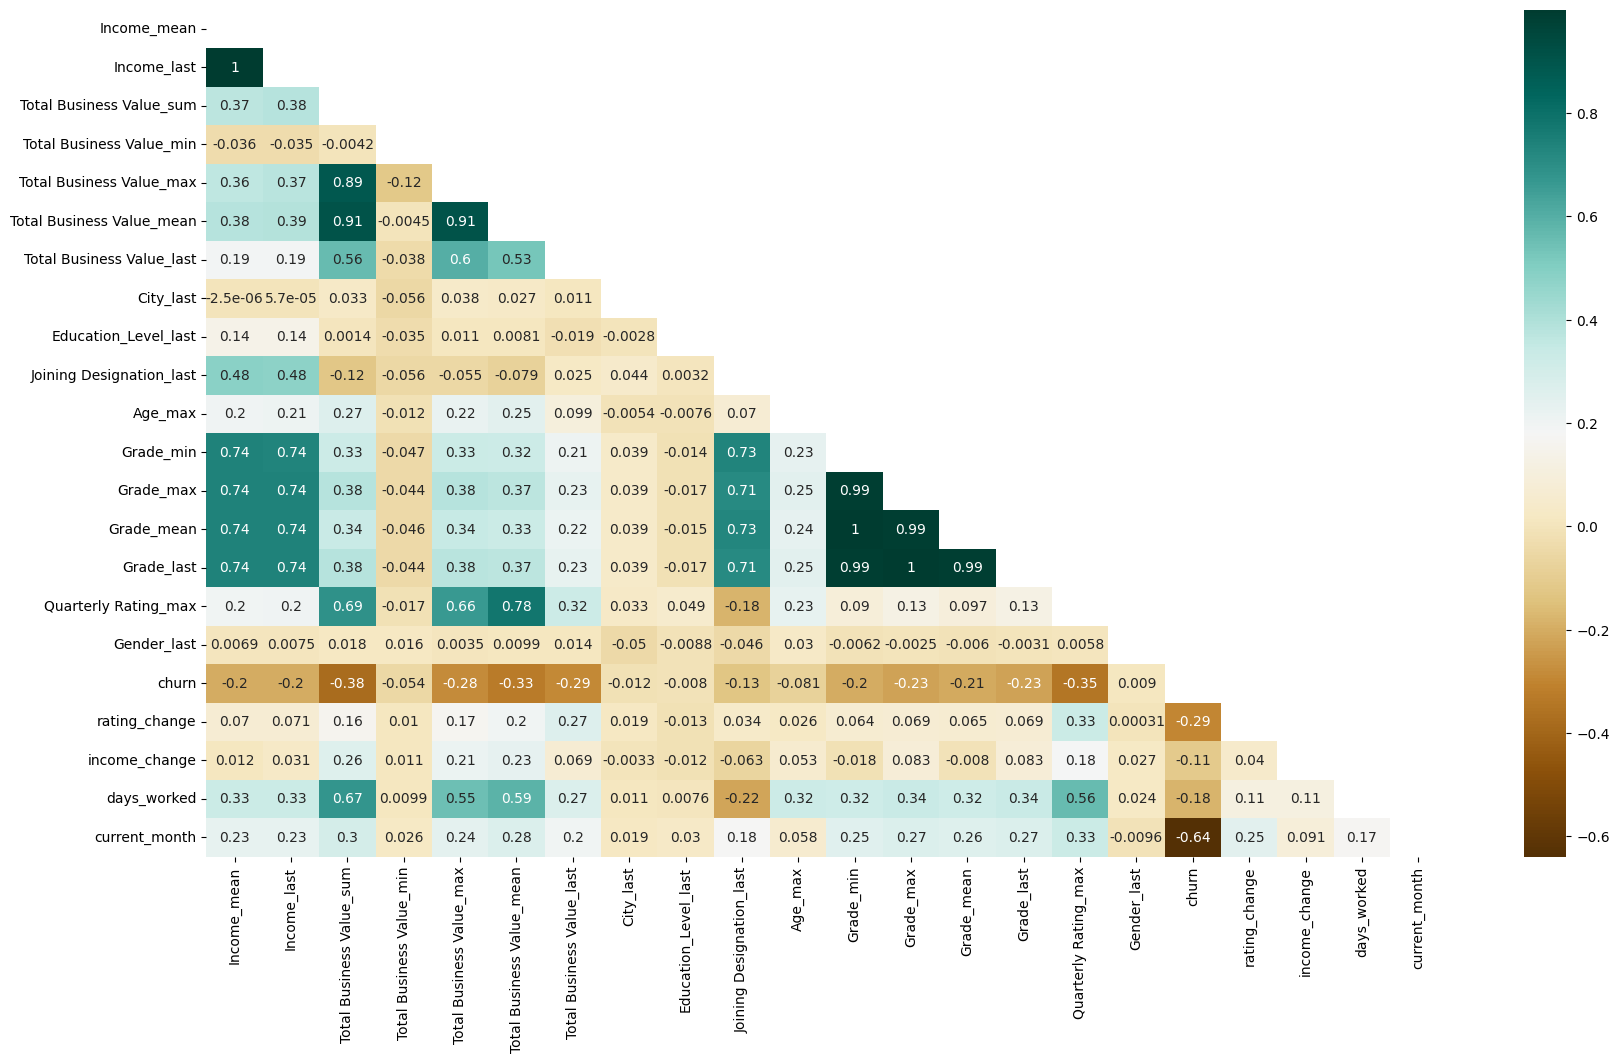

In [29]:
fig, ax = plt.subplots(figsize=(20,11))
sns.heatmap(modified_df.corr(), annot = True, cmap = 'BrBG', ax = ax, mask = np.triu(np.ones_like(modified_df.corr(), dtype=bool)))
plt.show()

In [30]:
modified_df.to_csv("/Users/praveenallam/Desktop/data_science_business_cases/data.csv",index = False)

In [31]:
modified_df.shape

(2381, 22)

In [32]:
modified_df.churn.value_counts()

churn
1    1616
0     765
Name: count, dtype: int64

### Data Preperation

In [33]:
# # global random_seed
# random_seed = 42

In [34]:
# modified_df.head()

In [35]:
# cols = ["City", "Education_Level", "Gender", "Joining Designation", "Quarterly Rating", "rating_change", "income_change"]

# display(modified_df[cols].nunique().reset_index())
# display(modified_df.dtypes.reset_index())

In [36]:
# te = TargetEncoder()
# te.fit(modified_df["City_last"].astype("category"),  modified_df["churn"])

# modified_df["City_last"] = te.transform(modified_df["City_last"].astype("category"),  modified_df["churn"])

In [37]:
# modified_df.head()

In [38]:
# X = modified_df.drop("churn", axis = 1).copy()
# y = modified_df.churn.copy()

In [39]:
# y.value_counts()

In [40]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_seed)

# print(f"shape of the data ")
# print("train: ")
# print(f"  X_train = {X_train.shape}")
# print(f"  y_train = {y_train.shape}")

# print("test: ")
# print(f"  X_test = {X_test.shape}")
# print(f"  y_test = {y_test.shape}")


In [41]:
# y_train.value_counts(normalize = True)

### Model

In [42]:
# global scores
# scores = {}

# def model_score(model_name, y_true, y_pred):
#     scores[model_name] = {"precession_score" : precision_score(y_true, y_pred), "recall_score" : recall_score(y_true, y_pred), "f1_score" : f1_score(y_true, y_pred)}

# def metric_scores(actual, pred, data_type):
#     print("-" * 70)
#     print(f"{data_type} data results:")
#     print(f"  accuracy_score = {accuracy_score(actual, pred)}")  
#     print(f"  precision_score = {precision_score(actual, pred)}") 
#     print(f"  recall_score = {recall_score(actual, pred)}") 
#     print(f"  f1_score = {f1_score(actual, pred)}") 
#     # print(classification_report(actual, pred))
#     if data_type == "test":  
#         print(f"  Confusion Matrix")
#         conf = confusion_matrix(actual, pred)
#         ConfusionMatrixDisplay(conf, display_labels = logisticRegression.classes_).plot()

# def grid_search_cv(model, param_grid, scoring, X_train, y_train, folds):

#     k_fold = KFold(n_splits = folds, shuffle = True, random_state = random_seed)

#     grid_search = GridSearchCV(model, param_grid, cv = k_fold, scoring = scoring, n_jobs = -1, verbose = 1) 
#     grid_search.fit(X_train, y_train)
    
#     print(f"best params = {grid_search.best_params_}")

#     return grid_search.best_estimator_ 

##### Logistic Regression Model

In [43]:
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train_sca = scaler.transform(X_train)
# X_test_sca = scaler.transform(X_test)

In [44]:
# logisticRegression = LogisticRegression()
# logisticRegression.fit(X_train_sca, y_train)

In [45]:
# print(f"Scores for logistic regression model\n")
# metric_scores(y_train, logisticRegression.predict(X_train_sca), data_type = "train")
# metric_scores(y_test, logisticRegression.predict(X_test_sca), data_type = "test")

In [46]:
# solvers = ["newton-cg", "lbfgs", "liblinear"]
# penalty = ["l1", "l2", "elasticnet"]
# c_values = [100, 10, 1.0, 0.1, 0.01]

# param_grid = dict(solver = solvers, penalty = penalty, C = c_values)

# logreg = grid_search_cv(LogisticRegression(random_state = random_seed, max_iter = 1000), param_grid, "f1", X_train_sca, y_train, folds = 10)
# logreg.fit(X_train_sca, y_train)

# print(f"Scores for logistic regression model (hyper parameters tuned)\n")
# metric_scores(y_train, logreg.predict(X_train_sca), data_type = "train")
# metric_scores(y_test, logreg.predict(X_test_sca), data_type = "test")

# # best params = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [47]:
# model_score("Logistic Regression", y_test, logreg.predict(X_test_sca))

##### Decision Tree Model

In [48]:
# decisionTreeClassifier = DecisionTreeClassifier()
# decisionTreeClassifier.fit(X_train, y_train)

In [49]:
# print(f"Scores for Decision Tree Classifier model\n")
# metric_scores(y_train, decisionTreeClassifier.predict(X_train), data_type = "train")
# metric_scores(y_test, decisionTreeClassifier.predict(X_test), data_type = "test")

In [50]:
# criterion = ["gini", "entropy", "log_loss"]
# splitter = ["best"]
# max_depth = [_ for _ in range(5,11,1)]
# ccp_alpha = [.1, .01, .001]
# max_features = ["sqrt", "log2"]
# # max_leaf_nodes = [_ for _ in range(0,100)]
# # min_samples_leaf = [_ for _ in range(0,100)]

# param_grid = dict(criterion = criterion,splitter = splitter,max_depth = max_depth, ccp_alpha = ccp_alpha, max_features = max_features)

# decisionTreeClassifier = grid_search_cv(DecisionTreeClassifier(random_state = random_seed), param_grid, "f1", X_train, y_train, folds = 5)
# decisionTreeClassifier.fit(X_train, y_train)

# print(f"\nScores for Decision Tree Classifier model (hyper parameters tuned)\n")
# metric_scores(y_train, decisionTreeClassifier.predict(X_train), data_type = "train")
# metric_scores(y_test, decisionTreeClassifier.predict(X_test), data_type = "test")

# # best params = {'ccp_alpha': 0.001, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'splitter': 'best'}

In [51]:
# model_score("Decision Tree Classifier", y_test, decisionTreeClassifier.predict(X_test))

#### Bagging - RandomForestClassifier model

In [52]:
# rfc_model = RandomForestClassifier()
# rfc_model.fit(X_train, y_train)

In [53]:
# print(f"Scores for RandomForest Classifier model\n")
# metric_scores(y_train, rfc_model.predict(X_train), data_type = "train")
# metric_scores(y_test, rfc_model.predict(X_test), data_type = "test")

In [54]:
# grid = {
#  "n_estimators":[val for val in range (10,1001, 100)],
#  "max_depth" : [val for val in range (3,20)],
# #  "min_samples_split" : [2, 5],
# #  "min_samples_leaf" : [2, 4,8],
#  "bootstrap" : [True],
#  "max_features": ['sqrt'],
#  "ccp_alpha" : [.1, .01, .001,.0001]
# }

# rfc_model = grid_search_cv(RandomForestClassifier(random_state = random_seed, class_weight = "balanced"), grid, "f1", X_train, y_train, folds = 5)
# rfc_model.fit(X_train, y_train)

# # best params = {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 900}
# # best params = {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 600}
# #  best params = {'bootstrap': True, 'ccp_alpha': 0.0001, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
# # best params = {'bootstrap': True, 'ccp_alpha': 0.001, 'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 110}


In [55]:
# print(f"\nScores for RandomForest Classifier model (hyper parameters tuned)\n")
# metric_scores(y_train, rfc_model.predict(X_train), data_type = "train")
# metric_scores(y_test, rfc_model.predict(X_test), data_type = "test")

In [56]:
# roc_auc_score(y_test, rfc_model.predict(X_test))

In [57]:
# model_score("RandomForest Classifier", y_test, rfc_model.predict(X_test))

#### Boosting GDBTClassifier

In [58]:
# gdbt_model = GradientBoostingClassifier()
# gdbt_model.fit(X_train, y_train)

In [59]:
# print(f"Scores for GradientBoosting Classifier model\n")
# metric_scores(y_train, gdbt_model.predict(X_train), data_type = "train")
# metric_scores(y_test, gdbt_model.predict(X_test), data_type = "test")

In [60]:
# param_grid = {
#     'n_estimators': [val for val in range (100,1001, 100)],
#     # 'max_features': ['sqrt','log2'],
#     'max_depth' : [val for val in range (3,11)],
#     # "min_samples_split" : [val for val in range(1,10,1)],
#     # "min_samples_leaf" : [val for val in range(1,10,1)],
#     "max_depth" : [val for val in range(1,10,1)],
#     "booster" : ["gbtree", "gblinear"],
#     "eta" : [.001,0.01,0.2,0.1,1,10]
# }

# xgboost = grid_search_cv(XGBClassifier(random_state = random_seed), param_grid, "accuracy", X_train, y_train, folds = 5)
# xgboost.fit(X_train, y_train)

In [61]:
# print(f"\nScores for GradientBoosting Classifier model (hyper parameters tuned)\n")
# metric_scores(y_train, gdbt_model.predict(X_train), data_type = "train")
# metric_scores(y_test, gdbt_model.predict(X_test), data_type = "test")

In [62]:
# model_score("GradientBoosting Classifier", y_test, gdbt_model.predict(X_test))

In [63]:
# scores

### EDA

In [64]:
# cities_income = df.groupby(by = "City").agg({"Income" : "mean", "Total Business Value" : "mean"}).sort_values(by = ["Total Business Value", "Income"], ascending = False)
# display(cities_income.iloc[0:7, :])

# cities_income.plot(kind = "bar", position = 0.5, width = 0.8)

In [65]:
# df.groupby(by = "Education_Level").agg({"Income" : "mean", "Total Business Value" : "mean"}).plot(kind = "bar", position = 0.5, width = 0.8)